In [1]:
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input,LayerNormalization, 
                                        GlobalMaxPooling1D, Conv1D, MaxPooling1D, Concatenate)
from tensorflow.keras.optimizers import Adam

## 1. Load Dataset

In [2]:
dataset = load_dataset('uit-nlp/vietnamese_students_feedback')
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 3166
    })
})

In [3]:
#Chuyển dataset thành dataframe
train_df = dataset['train'].to_pandas()
print('Train:', train_df.shape)
val_df = dataset['validation'].to_pandas()
print('Val: ', val_df.shape)
test_df = dataset['test'].to_pandas()
print('Test: ', test_df.shape)

#Gộp các df lại thành 1 df tên sentiment_data
sentiment_data = pd.concat([train_df, val_df, test_df], ignore_index = True)

#Xáo trộn thứ tự các dòng dataframe tránh việc mô hình học theo thứ tự dữ liệu, dẫn đến hiện tượng overfitting(học thuộc)
sentiment_data = sentiment_data.sample(frac = 1).reset_index(drop = True)
print('Sentiment data:', sentiment_data.shape)

#Đổi tên cột
sentiment_data = sentiment_data.rename(columns={'sentence' : 'comment','sentiment' : 'label'})
sentiment_data.head()

Train: (11426, 3)
Val:  (1583, 3)
Test:  (3166, 3)
Sentiment data: (16175, 3)


,comment,label,topic
0,thầy nên giảng bài nhanh hơn để sinh viên có t...,0,0
1,kỹ năng đọc của em còn chưa thể hiện được .,0,3
2,dạy quá thời gian quy định .,2,0
3,"nhiệt tình , chia sẻ kinh nghiệm học tập .",2,0
4,hợp tác .,1,3


## 2. Data preprocessing

### 2.1 Duplicated

In [4]:
# Đếm số hàng trùng lặp và xóa
print('Số dữ liệu bị lặp: ', sentiment_data['comment'].duplicated().sum())
sentiment_data = sentiment_data.drop_duplicates('comment')

# Kiểm tra lại sau khi xóa
print('Số dữ liệu bị lặp sau khi xóa: ', sentiment_data['comment'].duplicated().sum())

sentiment_data = sentiment_data.reset_index(drop = True)
sentiment_data.shape

Số dữ liệu bị lặp:  1
Số dữ liệu bị lặp sau khi xóa:  0


(16174, 3)

### 2.2 Missing

In [5]:
# Kiểm tra giá trị missing
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16174 entries, 0 to 16173
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  16174 non-null  object
 1   label    16174 non-null  int64 
 2   topic    16174 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 379.2+ KB


### 2.3 Over-sampling

In [6]:
def visualization_labels(sentiment_data):
    #Khảo sát
    label_counts = sentiment_data['label'].value_counts().sort_index()
    
    print('BỘ DỮ LIỆU CÓ SỐ DÒNG VÀ CỘT LÀ:', sentiment_data.shape)
    print('CÓ TẤT CẢ CÁC NHÃN VÀ SỐ LƯỢNG MỖI NHÃN LÀ:\n ', label_counts)
    
    #Trực quan hóa
    plt.figsize = (9,9)
    
    labels = ['Tiêu cực', 'Trung lập', 'Tích cực']
    mycolors = ['#009299', '#7ed957', '#00b980']
    plt.pie(label_counts, labels = labels, autopct = '%1.1f%%', startangle = 90, colors = mycolors)
    plt.title('Tỉ lệ số nhãn trong đánh giá')

BỘ DỮ LIỆU CÓ SỐ DÒNG VÀ CỘT LÀ: (16174, 3)
CÓ TẤT CẢ CÁC NHÃN VÀ SỐ LƯỢNG MỖI NHÃN LÀ:
  label
0    7439
1     698
2    8037
Name: count, dtype: int64


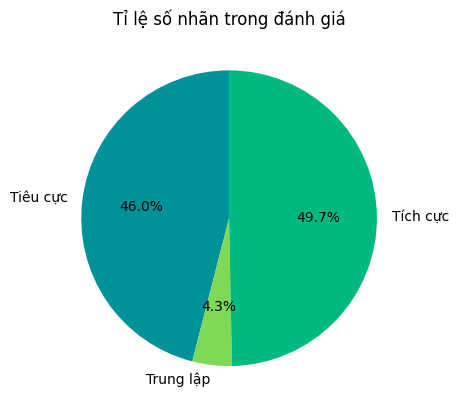

In [8]:
visualization_labels(sentiment_data)

In [7]:
from sklearn.utils import resample

train_comments = sentiment_data['comment'].values
# print(train_comments)

train_labels = sentiment_data['label'].values
# print(train_labels)

# Tìm chỉ số các câu trung lập(label=1)
neutral_indices = np.where(train_labels == 1)[0]

oversample_size = len(train_labels[train_labels ==0]) - len(neutral_indices)

oversampled_neutral_indices = resample(neutral_indices,
                                       replace = True,
                                       n_samples = oversample_size,
                                       random_state = 42)
oversampled_neutral_comments = train_comments[oversampled_neutral_indices]

train_comments_oversampled = np.concatenate([train_comments,oversampled_neutral_comments], axis = 0)
train_labels_oversampled = np.concatenate([train_labels, np.array([1]*oversample_size)], axis = 0)

In [8]:
sentiment_data_oversampled = pd.DataFrame({
    'comment' : train_comments_oversampled,
    'label' : train_labels_oversampled
})

sentiment_data = sentiment_data_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

BỘ DỮ LIỆU CÓ SỐ DÒNG VÀ CỘT LÀ: (22914, 2)
CÓ TẤT CẢ CÁC NHÃN VÀ SỐ LƯỢNG MỖI NHÃN LÀ:
  label
0    7438
1    7438
2    8038
Name: count, dtype: int64


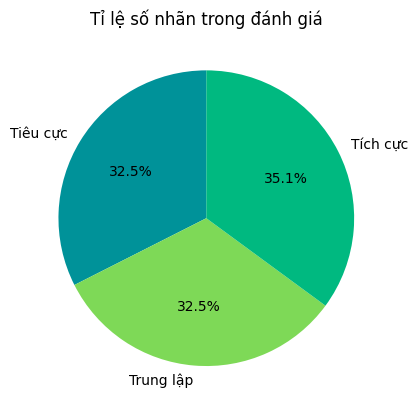

In [9]:
visualization_labels(sentiment_data)

### 2.4 Data normaliztion

In [10]:
import regex as re
import string
from underthesea import word_tokenize, text_normalize

#CHUẨN HÓA DỮ LIỆU
#Sử dụng hàm nhận diện icon 
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F" 
                u"\U0001F300-\U0001F5FF" 
                u"\U0001F680-\U0001F6FF" 
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0" 
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

def clean_text(text):
    
    text=text.lower()  #chuyển toàn bộ text về chữ thường 
    text=re.sub(emoji_pattern," ",text)    #loại bỏ icon
    text = re.sub(r'([a-z]+?)\1+',r'\1', text)  #loại bỏ các ký chữ lặp trong từ(aaaaabbbb--> ab)


    #Đảm bảo khoảng trắng trước và sau giữa các dấu câu --> se , ti
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)

    #Xóa bớt các dấu câu lặp lại --> !!!!->!
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+", r"\1", text)

    #Loại bỏ các dấu câu hoặc khoảng trắng ở đâu và cuối câu
    text=text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]

    #Loại bỏ tất cả các dấu câu
    text = text.translate(str.maketrans('', '', string.punctuation))

    #Loại bỏ các khoảng trắng dư thừa trong câu
    text = re.sub(r"\s+", " ", text)

    #Tách từ 
    text = text_normalize(text)
    text = word_tokenize(text, format="text")

    return text

In [ ]:
print('Câu gốc: ', sentiment_data['comment'][6])
print('Chuẩn hóa: ', clean_text(sentiment_data['comment'][6]))

In [11]:
sentiment_data['corpus'] = sentiment_data['comment'].map(lambda text: clean_text(text))                                                     
sentiment_data.head(20)

,comment,label,corpus
0,thầy dạy dễ hiểu bài tập đa dạng .,2,thầy dạy dễ hiểu bài_tập đa_dạng
1,em thích nhất là phần dạy lý thuyết của thầy .,2,em thích nhất là phần dạy lý_thuyết của thầy
2,giống như việc cung cấp cho phép cộng và yêu c...,1,giống như việc cung_cấp cho_phép cộng và yêu_c...
3,tạm tạm .,1,tạm tạm
4,thầy tạo được sự hứng thú với môn học .,2,thầy tạo được sự hứng_thú với môn_học
5,thầy viết chữ rất đẹp !,2,thầy viết chữ rất đẹp
6,giảng viên cho bài tập để làm .,1,giảng_viên cho bài_tập để làm
7,bài tập và hướng dẫn giải bài tập trên lớp .,1,bài_tập và hướng_dẫn_giải bài_tập trên lớp
8,thực hiện nhóm nhiều .,1,thực_hiện nhóm nhiều
9,em có ý kiến là hãy thi môn này trên máy tính ...,0,em có ý_kiến là hãy thi_môn này trên máy_tính ...


### 2.5 Visualization

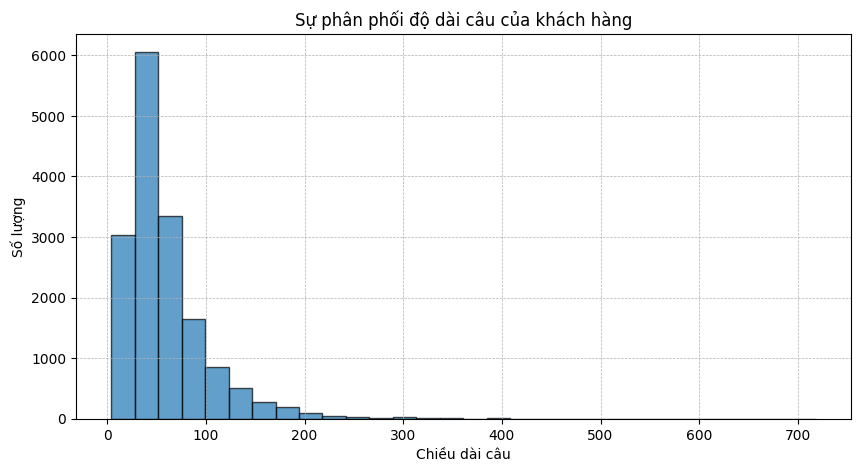

In [13]:
#Xem chiều dài của comment tập trung chủ yếu bao nhiêu 
lengths = sentiment_data['comment'].apply(len)

#Biểu đồ histogram
plt.figure(figsize=(10,5))
plt.hist(lengths, edgecolor='k', bins=30, alpha=0.7)#bin=30 chia khoảng giá trị thành 30 nhóm 
plt.title('Sự phân phối độ dài câu của khách hàng')
plt.xlabel('Chiều dài câu')
plt.ylabel('Số lượng')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

In [ ]:
import nltk
import wordcloud

#XEM TRẠNG THÁI BAN ĐẦU CHƯA DỰ ĐOÁN CỦA BỘ DỮ LIỆU 

#Lọc bỏ các khoảng trắng chỉ lấy chữ
all_words= [token for token in sentiment_data['corpus'].tolist() if token and token!=' ']
 
corpus=' '.join(all_words)   #Nối lại thành chuỗi
all_words = nltk.FreqDist(all_words)  #Tính tần suất xuất hiện của từng từ trong danh sách 

print('Số tất cả từ: {}'.format(len(all_words)))
print('Số từ xuất hiện nhiều nhất top 15: {}'.format(all_words.most_common(15)))


plt.figure(figsize=(12,8))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(corpus)

plt.axis("off")  #tắt hiển thị các trục 
plt.imshow(word_cloud)


## 3. Machine Learning Model

### 3.1. Data Preparation

In [ ]:
from sklearn.model_selection import train_test_split 

# Tách cột 'corpus' chứa văn bản đã chuẩn hóa làm input (X)
X = sentiment_data['corpus']

# Tách cột 'label' làm nhãn đầu ra (y), và đảm bảo kiểu dữ liệu là int
y = sentiment_data['label'].astype(int)  

# Chia dữ liệu thành tập train và test (tỷ lệ test = 20%), 
# random_state=42 để đảm bảo tái lập (reproducibility),
# stratify=y để giữ tỉ lệ phân bố nhãn trong cả train và test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer  

# Khởi tạo vectorizer với:
# - max_features=5000: chỉ giữ lại 5000 từ đặc trưng nhất (giảm chiều dữ liệu)
# - ngram_range=(1,2): dùng cả unigram (1 từ) và bigram (2 từ liên tiếp)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Học và biến đổi dữ liệu train thành ma trận TF-IDF
X_train_tfidf = tfidf.fit_transform(X_train)

# Biến đổi dữ liệu test (dựa trên từ vựng đã học ở train)
X_test_tfidf = tfidf.transform(X_test)

### 3.2. Naive Bayes Model

In [ ]:
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Bắt đầu đếm thời gian huấn luyện
start_MNB = time.time()

# Khởi tạo và huấn luyện mô hình
classifier_MNB = MultinomialNB()
classifier_MNB.fit(X_train_tfidf, y_train)

# Kết thúc đếm thời gian huấn luyện
end_MNB = time.time()
time_MNB = end_MNB - start_MNB

print("Thời gian huấn luyện Multinomial Naive Bayes: ", str(time_MNB), " giây")

In [ ]:
# Dự đoán nhãn cho tập test
y_pred_MNB = classifier_MNB.predict(X_test_tfidf)

# Đánh giá kết quả
print('Độ chính xác Multinomial Naive Bayes:', accuracy_score(y_test, y_pred_MNB))
print('\nReport:\n', classification_report(y_test, y_pred_MNB, target_names=['Tiêu cực', 'Trung lập', 'Tích cực']))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm_MNB = confusion_matrix(y_test, y_pred_MNB)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_MNB, annot=True, fmt='d', cmap='Blues', xticklabels=['Tiêu cực', 'Trung lập', 'Tích cực'], yticklabels=['Tiêu cực', 'Trung lập', 'Tích cực'])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Naive Bayes Model')
plt.show()

In [ ]:
import joblib

joblib.dump(classifier_MNB, 'multinomial_naive_bayes_model.pkl')
print("Model saved successfully.")

### 3.3. Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
# Kiểm tra thời gian huấn luyện
start_LR = time.time()

classifier_LR = LogisticRegression(max_iter=1000, random_state=0)
classifier_LR.fit(X_train_tfidf, y_train)

end_LR = time.time()
time_LR = end_LR - start_LR

print("Thời gian huấn luyện: ", str(time_LR), " giây")

In [ ]:
y_pred_LR = classifier_LR.predict(X_test_tfidf)

print('Độ chính xác Logistic Regression:', accuracy_score(y_test, y_pred_LR))
print('\nReport:\n', classification_report(y_test, y_pred_LR, target_names=['Tiêu cực', 'Trung lập', 'Tích cực']))

In [ ]:
cm_LR = confusion_matrix(y_test, y_pred_LR)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_LR, annot=True, fmt='d', cmap='Blues', xticklabels=['Tiêu cực', 'Trung lập', 'Tích cực'], yticklabels=['Tiêu cực', 'Trung lập', 'Tích cực'])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Logistic Regression')
plt.show()

In [ ]:
joblib.dump(classifier_LR, 'logistic_regression_model.pkl')
print("Model saved successfully.")

## 4. Deep Learning Model

### 4.1 Data preparation

In [12]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pickle

from sklearn.model_selection import train_test_split

input_pre = sentiment_data['corpus'].tolist()
label_with_accent = sentiment_data['label'].tolist()

label_tf = to_categorical(label_with_accent, num_classes = 3)
input_pre = [str(item) for item in input_pre] #Biến đổi nhãn (label) thành ma trận on-hot encoding.

#Phân tách dữ liệu văn bản đầu vào
tokenizer_data = Tokenizer(oov_token = '<00V>') # gán các từ chưa máy chưa học thì sẽ gán bằng mã '<00V>' để tránh lỗi khi xử lý 
tokenizer_data.fit_on_texts(input_pre)  # tách từ + đếm số lần xuất hiện tạo thành một từ điển 

#Chuyển đổi văn bản thành vector số
tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)   #Biến đổi các văn bản trong input_pre (chuỗi) thành danh sách các chuỗi số,tương ứng từ được thay thế bằng chỉ số tương ứng trong từ điển
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen = 45)  # Làm cho tất cả các chuỗi trong tokenized_data_text có cùng độ dài (ở đây là 45), nếu <45 thì thêm 0, ngược thì thì cắt bớt

#Lưu tokenizer(word_index) vào file nhằm mục đích tái sử dụng
pickle.dump(tokenizer_data, open('tokenizer_data.pkl','wb'))

# Chuyển vec_data thành numpy
vec_data = np.array(vec_data)  
print("Input data shape:", vec_data.shape)

# Lấy size từ vựng
data_vocab_size = len(tokenizer_data.word_index) + 1
print("Data vocab size:", data_vocab_size)

# Chia dữ liệu training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size = 0.2, random_state = 42)
'''
    vec_data: là dữ liệu đầu vào sau khi đã sử lý với chiều dài là 45
    label_tf: là nhãn tương ứng với dữ liệu đầu vào đã được mã hóa ở dạng one-host encoding
    test_size=0.2 : lấy 20% cho tập validation và còn lại 80% cho tập training
    random_state=42: đảm bảo dữ liệu được lấy ngẫu nhiên 
'''
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)
'''
    X_train: là dữ liệu đầu vào
    y_train: là nhãn tương ứng với dữ liệu đầu vào
    test_size=0.1 : lấy 10% cho tập test từ tập training
    random_state=42: đảm bảo dữ liệu được lấy ngẫu nhiên 
'''
#training: chiếm 78%
# validation: chiếm 20%
# test: 8%


print("Training sample:", len(X_train))
print("Validation sample:", len(X_val))
print("Test sample:", len(X_test))

Input data shape: (22914, 45)
Data vocab size: 2817
Training sample: 16497
Validation sample: 4583
Test sample: 1834


In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted"
    )
    return {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }

### 4.2 Model CNN +Bi-LSTM

In [ ]:
def model_cnn_bilstm():
    dropout_threshold = 0.4 # dùng để xác định tỉ lệ dropout trong mô hình, có nghĩa là trong mỗi lần huấn luyện thì sẽ có 40% cái connect sẽ bị ngắt kết nối ngẫu nhiên 
    input_dim = data_vocab_size # số từ vựng 
    output_dim = 32 # mỗi từ trong từ điển sẽ được ánh xạ với một vector là 32 chiều 
    input_length = 45
    initializer = tf.keras.initializers.GlorotNormal() # để tạo 1 trọng số ban đầu không phải là theo một cách ngẫu nhiên mà có tính toán cụ thể

    # Tầng đầu vào 
    input_layer = Input(shape=(input_length,)) # định ngĩa lớp đầu tiên của mô hình với một chiều dài cố định 

    # Tầng embedding --> nhằm mục đích chuyển đổi các chỉ số nguyên(các từ) thành vector nhúng
    feature = Embedding(input_dim=input_dim, #số tất cả các từ vựng 
                        output_dim=output_dim, # mỗi từ được biểu diễn 1 vector nhúng 32 chiều 
                        input_length=input_length,#độ dài chuỗi đầu vào 
                        embeddings_initializer=initializer)(input_layer)#khởi tạo các giá trị trong bảng nhúng 

    # CNN feature 
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    '''
    --> Conv1D: tạo 1 lớp tích chập quét dữ liệu 1 chiều dọc 
    filters=32: có 32 bộ lọc 
    kernel_size=3: kích thước bộ lọc =3--> mỗi lần quét sẽ là 3 từ
    padding='same': đầu ra sẽ cùng kích thước đầu vào 
    activation='relu': tính toán dữ liệu đầu vào dựa theo hàm relu (>0 thì nhận ,<0 thì =0)
    '''
    cnn_feature = MaxPooling1D()(cnn_feature)#--> là giảm kích thước dữ liệu 
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)#-->giảm thiểu overfitting
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature) #chuẩn hóa các đặc trưng trong một lớp, giúp giảm thiểu các vấn đề về độ lệch chuẩn của các giá trị và giúp quá trình huấn luyện trở nên ổn định hơn.
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # BiLSTM feature 
    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True,kernel_initializer=initializer), merge_mode='concat')(feature)
    ''' merge_mode='concat': nghĩa là nếu lstm có 32 chiều thì mô hình hình sẽ tạo ra 64 chiều,32 chiều trước, 32 chiều sau '''
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

    # BiGRU feature 
    bi_lstm_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, return_sequences=True,kernel_initializer=initializer), merge_mode='concat')(bi_lstm_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    # Combine features
    combine_feature = Concatenate()([cnn_feature, bi_lstm_feature]) # kết nối 2 feature lại thành 1 feature mới 
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    # Tầng 
    classifier = Dense(90, activation='relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    
    classifier = Dense(70, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    
    classifier = Dense(30, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)

    # Định nghĩa mô hình
    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model

In [ ]:
model = model_cnn_bilstm()
adam = Adam(learning_rate=0.001)  # khởi tạo bộ tốc độ học với tốc độ 0.001
model.compile(optimizer = adam,loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

In [ ]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.keras', monitor='val_loss')
'''lưu trạng thái tốt nhất của mô hình trong quá trình huấn luyện 
monitor='val_loss': dựa trên giá trị val_loss nhỏ nhất
--> khi val_loss giảm hơn so với epochs trước đó thì sẽ được lưu vào mô hình 
'''
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, callbacks=[callback_model])

In [ ]:
from tensorflow.keras.models import load_model

model.load_weights("model_cnn_bilstm.keras")

y_true_cnn_bilstm = y_test.argmax(axis=1)

y_pred_probs_cnn_bilstm = model.predict(X_test)
y_pred_cnn_bilstm = y_pred_probs_cnn_BiLstm.argmax(axis=1) 

results = calculate_results(y_true_cnn_bilstm, y_pred_cnn_bilstm)
print(results)

### 4.3 Model PhoBERT

In [14]:
from transformers import AutoTokenizer

# Load tokenizer và model từ HuggingFace
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

X_train_cleaned = [str(x) for x in list(X_train)]  # đảm bảo kiểu str
encoded_train = tokenizer(X_train_cleaned,
    padding = 'max_length',
    truncation = True,
    max_length = 45,
    return_tensors = 'pt',
    return_attention_mask = True
)
train_ids = encoded_train['input_ids']            # Tensor: các token ID
train_masks = encoded_train['attention_mask']     # Tensor: attention mask


X_val_cleaned = [str(x) for x in list(X_val)]
encoded_val = tokenizer(
    X_val_cleaned, 
    padding = 'max_length', 
    truncation = True, 
    max_length = 45, 
    return_tensors = 'pt', 
    return_attention_mask = True
)
val_ids = encoded_val['input_ids']           
val_masks = encoded_val['attention_mask']   


X_test_cleaned = [str(x) for x in list(X_test)]  
encoded_test = tokenizer(
    X_test_cleaned, 
    padding = 'max_length', 
    truncation = True, 
    max_length = 45, 
    return_tensors = 'pt', 
    return_attention_mask = True)
test_ids = encoded_test['input_ids']            
test_masks = encoded_test['attention_mask']    

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch


#Chuyển đổi các danh sách thành tensor
train_inputs = torch.tensor(train_ids)
train_labels = torch.tensor(y_train)
train_masks = torch.tensor(train_masks)

val_inputs = torch.tensor(val_ids)
val_labels = torch.tensor(y_val)
val_masks = torch.tensor(val_masks)

test_inputs = torch.tensor(test_ids)
test_labels = torch.tensor(y_test)
test_masks = torch.tensor(test_masks)

#Tạo dataloader cho tập huấn luyện
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data,sampler = train_sampler, batch_size = 32)

#Tạo dataloader cho tập đánh giá
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = 32)

#Tạo dataloader cho tập kiểm tra
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data,sampler = test_sampler, batch_size = 32)

In [ ]:
from transformers import AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import torch
import numpy as np

epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_phobert = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)
model_phobert.to(device)

# Group tham số có decay và không decay
param_optimizer = list(model_phobert.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay': 0.01
    },
    {
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0
    }
]

optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * epochs
)

best_eval = 0

# Hàm đánh giá accuracy và f1
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def flat_accuracy(preds, labels):
    preds = np.argmax(preds, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    prec = precision_score(labels, preds, average='weighted')
    rec = recall_score(labels, preds, average='weighted')
    return acc, f1, prec, rec

# Vòng lặp huấn luyện
for epoch_i in range(epochs):
    print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")
    print("Training...")

    total_loss = 0
    model_phobert.train()
    train_accuracy = 0
    train_f1 = 0
    nb_train_steps = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Đảm bảo labels là LongTensor 1D
        if b_labels.ndim > 1:
            b_labels = torch.argmax(b_labels, dim=1)
        b_labels = b_labels.long()

        model_phobert.zero_grad()

        outputs = model_phobert(
            b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels
        )

        loss = outputs.loss
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.detach().cpu().numpy()

        acc, f1, prec, rec = flat_accuracy(logits, label_ids)
        train_accuracy += acc
        train_f1 += f1
        nb_train_steps += 1
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_phobert.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Train Accuracy: {train_accuracy / nb_train_steps:.4f}")
    print(f"Train F1 score: {train_f1 / nb_train_steps:.4f}")
    print(f"Average train loss: {avg_train_loss:.4f}")

    print("Running Validation...")
    model_phobert.eval()
    eval_accuracy = 0
    eval_f1 = 0
    nb_eval_steps = 0

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        if b_labels.ndim > 1:
            b_labels = torch.argmax(b_labels, dim=1)
        b_labels = b_labels.long()

        with torch.no_grad():
            outputs = model_phobert(
                b_input_ids,
                attention_mask=b_input_mask
            )
            logits = outputs.logits.detach().cpu().numpy()
            label_ids = b_labels.detach().cpu().numpy()

            acc, f1, prec, rec = flat_accuracy(logits, label_ids)
            eval_accuracy += acc
            eval_f1 += f1
            nb_eval_steps += 1

    print(f"Val Accuracy: {eval_accuracy / nb_eval_steps:.4f}")
    print(f"Val F1 score: {eval_f1 / nb_eval_steps:.4f}")
    print(f"Val Precision: {prec:.4f}")
    print(f"Val Recall: {rec:.4f}")

    if (eval_accuracy / nb_eval_steps) > best_eval:
        best_eval = (eval_accuracy / nb_eval_steps)
        model_phobert.save_pretrained('bert_pretrain_v2/')
        print("✅ Saved Best Model!")

print("🎉 Training complete!")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 10 ========
Training...


100%|██████████████████████████████████████████████████████████████████████████████| 516/516 [1:06:34<00:00,  7.74s/it]


Train Accuracy: 0.7082
Train F1 score: 0.7017
Average train loss: 0.6705
Running Validation...


In [24]:
config = RobertaConfig.from_pretrained(
    "./bert_pretrain", num_labels=3, local_files_only=True
)

model = RobertaForSequenceClassification.from_pretrained(
    "./bert_pretrain", config=config, local_files_only=True
)


In [25]:
# Import AutoTokenizer từ thư viện transformers
from transformers import AutoTokenizer

# Tải tokenizer cho mô hình PhoBERT
tkn = AutoTokenizer.from_pretrained("wonrax/phobert-base-vietnamese-sentiment", use_fast=False)

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [29]:
def BERT_Predict(text):
    """
    Dự đoán nhãn cảm xúc cho một câu (text).
    ['NEG', 'NEU', 'POS'] tương ứng với ['0', '1', '2']
    """
    text = str(text)  # Ép kiểu để tránh lỗi
    inputs = tkn(text, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        outputs = model_phobert(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class


In [30]:
# Tạo danh sách để lưu kết quả dự đoán cho tập kiểm tra
test_pred = []
for cmt in X_test:
  test_pred.append(BERT_Predict(cmt))

In [45]:
# y_test = np.argmax(y_test, axis=1)

calculate_results(test_pred,y_test)

{'accuracy': 90.1854714064915,
 'precision': 0.914713772497933,
 'recall': 0.901854714064915,
 'f1': 0.9076610557237382}

In [38]:

y_test
y_test = np.argmax(y_test, axis=1)

array([0, 0, 2, ..., 2, 2, 0])

## 5. Compare Model

## 6. Test

In [ ]:
# Hàm tiền xử lý đầu vào
def preprocess_raw_input(raw_input, tokenizer):

    input_text_pre=clean_text(raw_input)
    print("Text:", input_text_pre)

    # Chuyển đổi văn bản thành vector số 
    tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre])
    vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=45)  # padding cho dữ liệu
    return vec_data

# Hàm dự đoán với mô hình
def inference_model(input_feature, model):
    output = model(input_feature).numpy()[0]
    result = output.argmax()  # Lấy chỉ số lớp có giá trị dự đoán cao nhất
    conf = float(output.max())  # Độ tin cậy của dự đoán (giá trị dự đoán cao nhất)
    label_dict = {'Tiêu cực': 0, 'Trung lập': 1, 'Tích cực': 2}
    labels = list(label_dict.keys())  # Lấy các nhãn
    return labels[int(result)], conf  # Trả về nhãn và độ tin cậy

# Hàm dự đoán cuối cùng
def prediction(raw_input, tokenizer, model):
    input_model = preprocess_raw_input(raw_input, tokenizer)  # Tiền xử lý đầu vào
    result, conf = inference_model(input_model, model)  # Dự đoán với mô hình
    return result, conf  # Trả về kết quả và độ tin cậy


In [ ]:
my_model=generate_model()
my_model=load_model("model_cnn_bilstm.keras")

with open (r"tokenizer_data.pkl","rb") as input_file:
    my_tokenizer=pickle.load(input_file)
print(prediction("Thầy giảng hay lắm!!",my_tokenizer,my_model))

In [ ]:
while True:
    text = input("Nhập văn bản (hoặc gõ 'end' để kết thúc): ")
    if text.lower() == "end":
        break
    else:
        # Dự đoán và in kết quả
        prediction_result = prediction(text, my_tokenizer, my_model)
        print(str(prediction_result) + "\n")  # Đảm bảo kết quả là chuỗi trước khi nối

Text: tôi buồn
('Tiêu cực', 0.9421778321266174)



Nhập văn bản (hoặc gõ 'end' để kết thúc):  end


In [ ]:
from tensorflow.keras.utils import plot_model
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)